<a href="https://colab.research.google.com/github/tomonari-masada/course2022-sml/blob/main/13_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality reduction （次元圧縮, 次元削減）
* 可視化については、下記ページを参考にした。
 * https://plotly.com/python/pca-visualization/
 * https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29
* 次元圧縮については、下記ページを参考にした。
 * https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA, NMF, FastICA

%config InlineBackend.figure_format = 'retina'

## データの取得
* Sign MNISTというデータセットを使う。(The American Sign Language letter database)
 * https://www.kaggle.com/datamunge/sign-language-mnist
* あらかじめダウンロードしておき、Google Driveに保存しておく。

In [2]:
train = pd.read_csv('/content/drive/MyDrive/2021Courses/SML/sign_mnist_train.csv')
train.head()
test = pd.read_csv('/content/drive/MyDrive/2021Courses/SML/sign_mnist_test.csv')
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


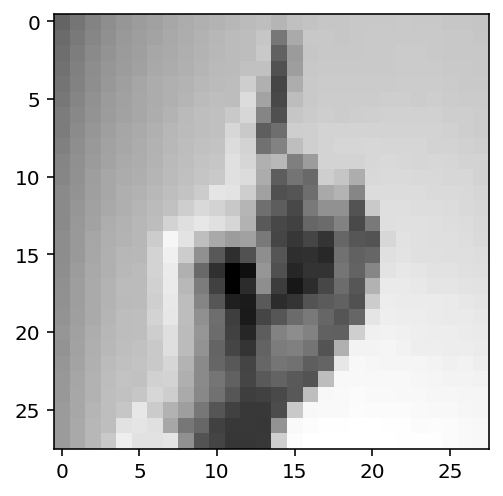

In [3]:
plt.imshow(train.loc[0,'pixel1':].to_numpy().reshape(28,28), cmap=plt.cm.gray);

In [4]:
# Setting the label and the feature columns
y_train = train.loc[:,'label'].values
X_train = train.loc[:,'pixel1':].values
y_test = test.loc[:,'label'].values
X_test = test.loc[:,'pixel1':].values

In [5]:
print(X_train.shape, X_test.shape)

(27455, 784) (7172, 784)


* 25種類あるらしい。

In [6]:
for item in zip(*np.unique(y_train, return_counts=True)):
  print(item)

(0, 1126)
(1, 1010)
(2, 1144)
(3, 1196)
(4, 957)
(5, 1204)
(6, 1090)
(7, 1013)
(8, 1162)
(10, 1114)
(11, 1241)
(12, 1055)
(13, 1151)
(14, 1196)
(15, 1088)
(16, 1279)
(17, 1294)
(18, 1199)
(19, 1186)
(20, 1161)
(21, 1082)
(22, 1225)
(23, 1164)
(24, 1118)


## データの前処理
* scikit-learnのドキュメンテーションにあるやり方に倣った。
 * まず訓練データセット全体での各ピクセルの平均値を引き算し・・・
 * 次に各画像内でのローカルな平均値を引き算する。

In [7]:
# global centering
train_mean = X_train.mean(axis=0) # 訓練データ全体でのピクセルごとの平均値
X_train_centered = X_train - train_mean
X_test_centered = X_test - train_mean

In [8]:
# local centering
X_train_centered -= X_train_centered.mean(axis=1).reshape(-1, 1)
X_test_centered -= X_test_centered.mean(axis=1).reshape(-1, 1) # インスタンスごとの計算なので許される。

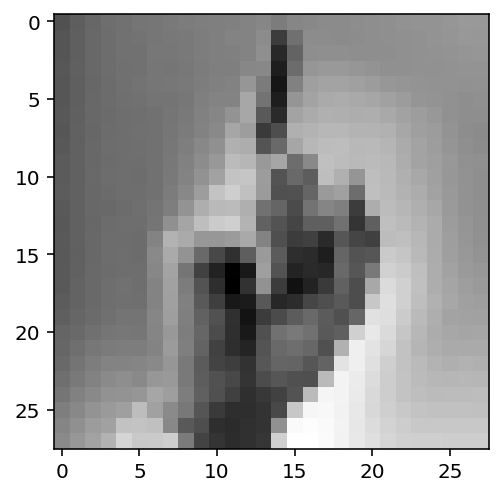

In [9]:
plt.imshow(X_train_centered[0,:].reshape(28,28), cmap=plt.cm.gray);

## PCAによる可視化
* 第3主成分までを取り、データ集合を可視化。

In [12]:
from sklearn.decomposition import PCA

start = time.time()
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_centered)
print('Duration: {} seconds'.format(time.time() - start))

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(
    margin=dict(l=40, r=40, b=40, t=40),
    width=900,
    height=500
)
fig.show()

Duration: 4.296268939971924 seconds


## 次元圧縮手法によるデータの再構成(reconstruction)
* 様々な次元圧縮手法を使って元のデータを低次元空間にマッピングする。
* そしてそれを元の空間へ戻すことでreconstructする。
 * reconstructionは、次元圧縮手法ごとに異なる。
 * inverse_transformというメソッドを呼べばよい。

* 画像を複数描画する関数を定義しておく。

In [14]:
def plot_gallery(title, images, n_col=3, n_row=3, cmap=plt.cm.gray):
  plt.figure(figsize=(2. * n_col, 2.26 * n_row))
  plt.suptitle(title, size=16)
  for i, comp in enumerate(images):
    plt.subplot(n_row, n_col, i + 1)
    vmax = max(comp.max(), -comp.min())
    plt.imshow(comp.reshape(28, 28), cmap=cmap,
               interpolation='nearest',
               vmin=-vmax, vmax=vmax)
    plt.xticks(())
    plt.yticks(())
  plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.);

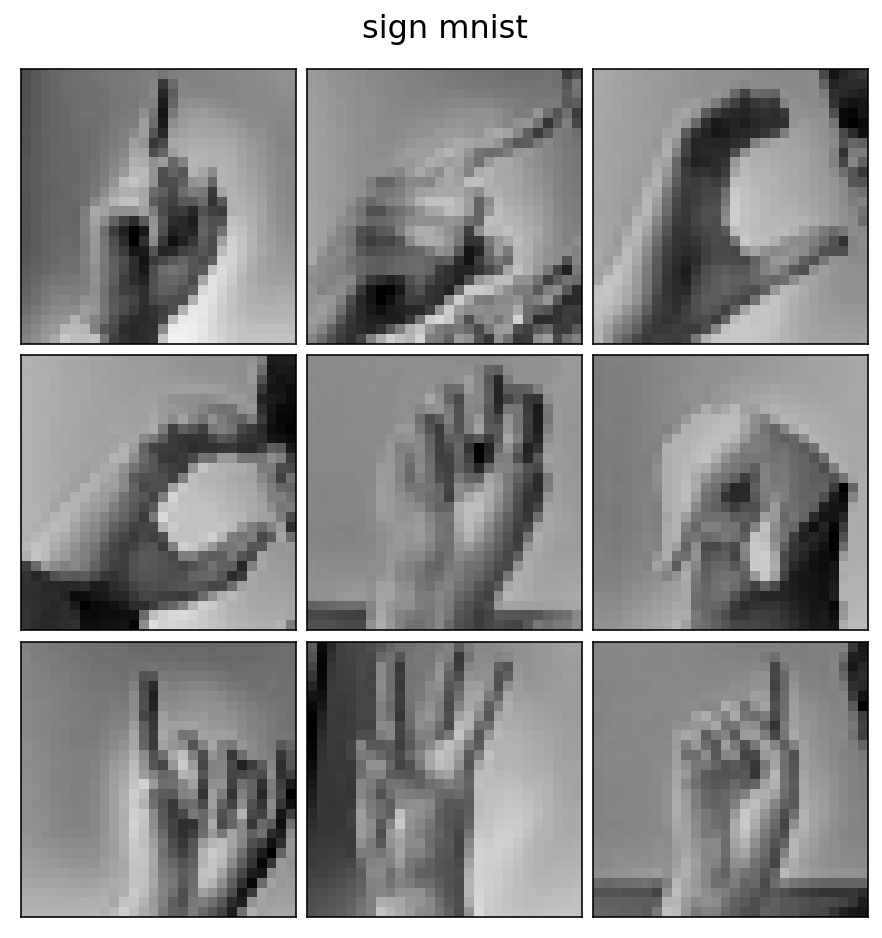

In [15]:
plot_gallery("sign mnist", X_train_centered[:9], n_row=3, n_col=3)

### PCAの主成分を可視化する
* PCAでは、主成分principal componentsの線型結合によって元の画像を再構成することになる。


In [16]:
n_components = 30
estimator = PCA(n_components=n_components, svd_solver='randomized')
estimator.fit(X_train_centered)

PCA(n_components=30, svd_solver='randomized')

In [17]:
n_col = 6

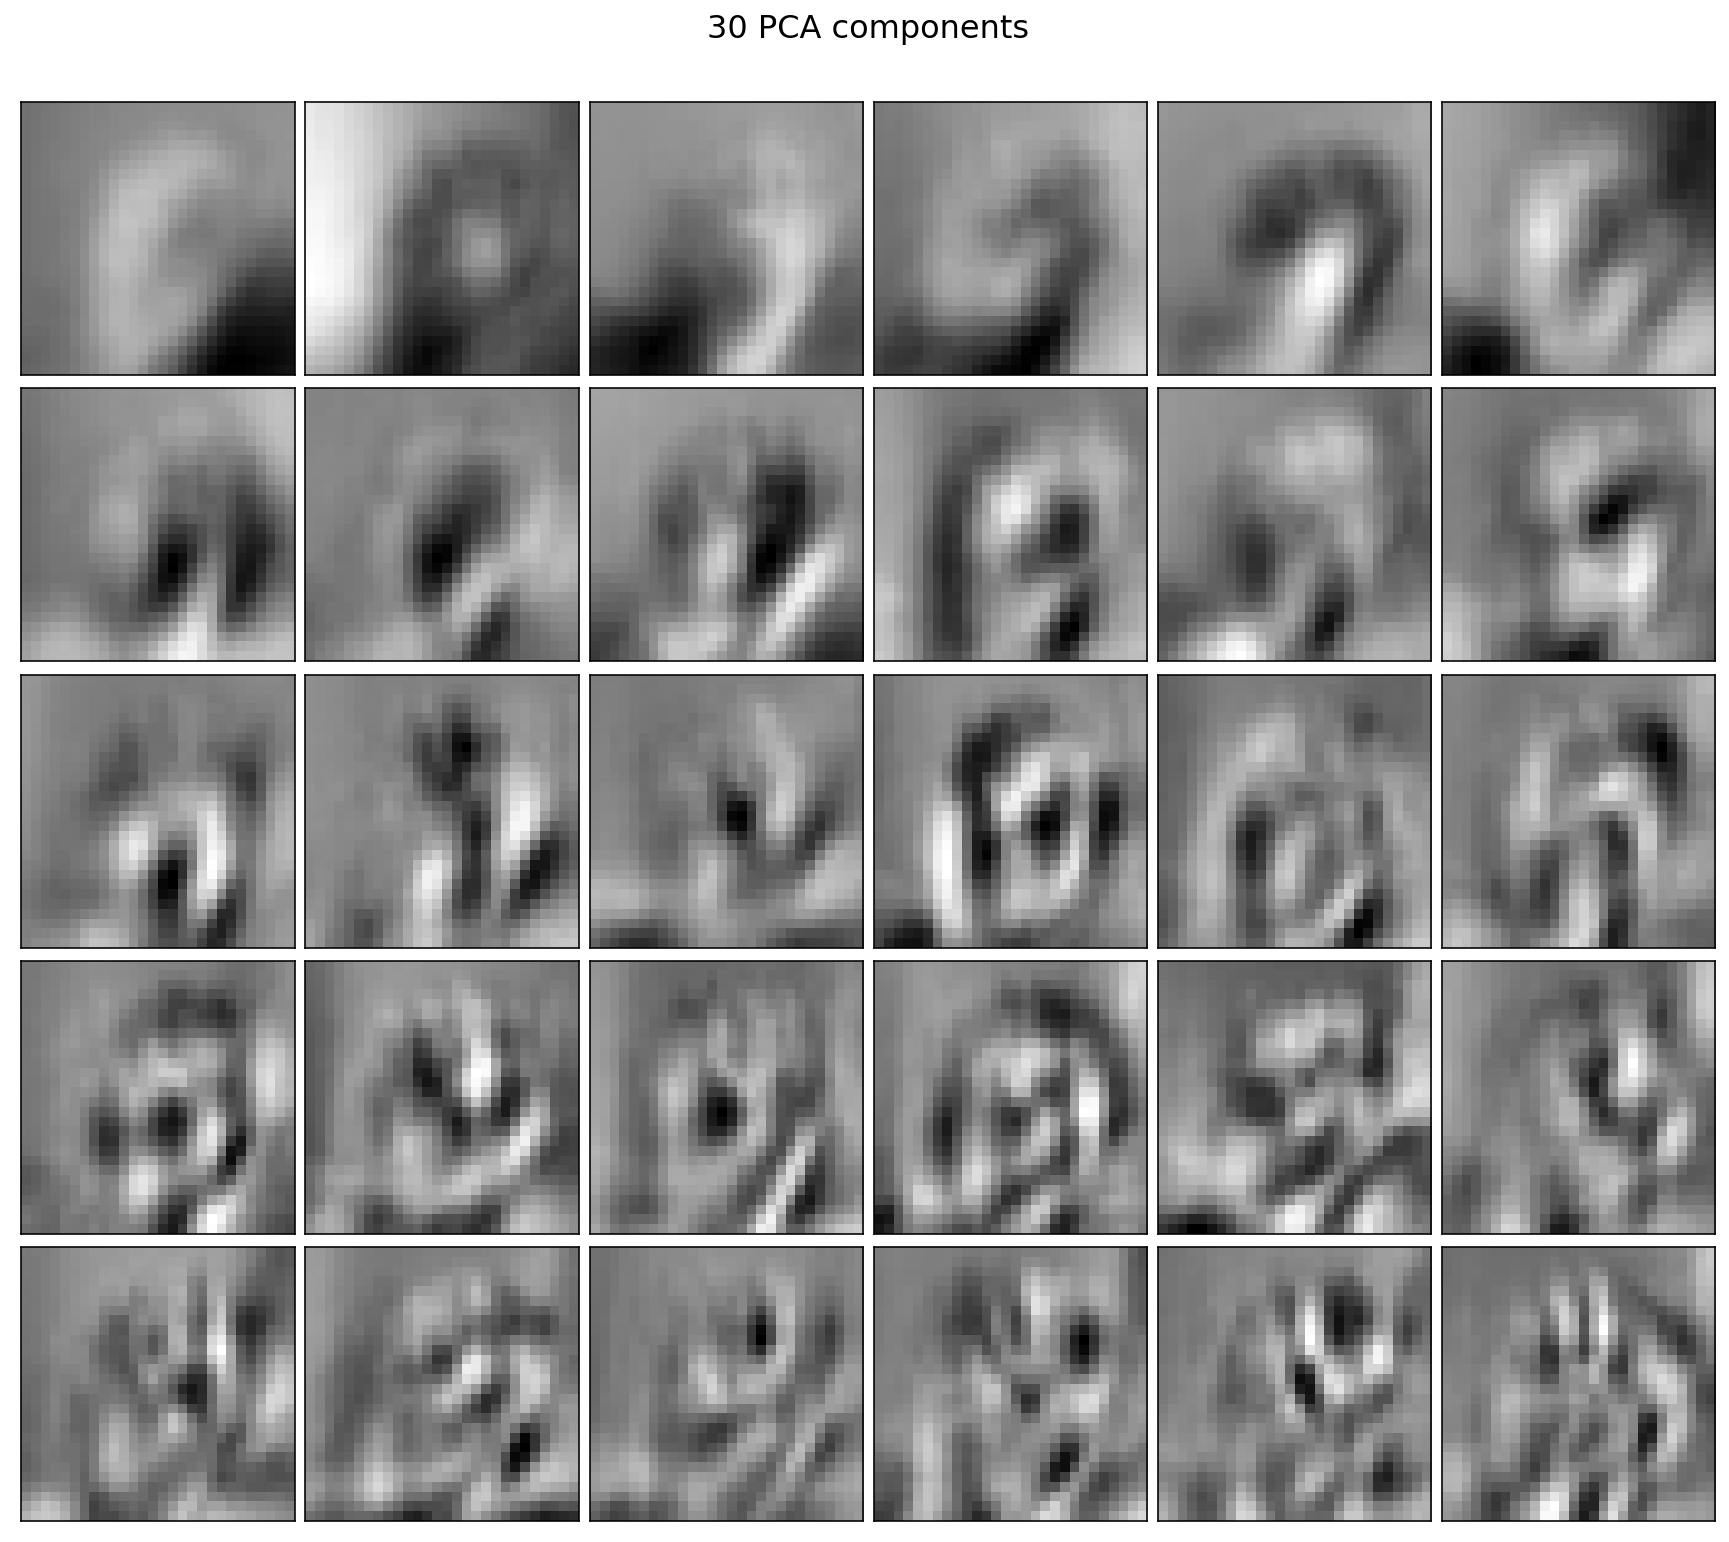

In [18]:
n_row = n_components // n_col + (n_components % n_col != 0)
plot_gallery(f"{n_components} PCA components", estimator.components_[:n_components],
             n_row=n_row, n_col=n_col)

* 8枚ほどの画像について、オリジナルと再構成を比較してみる。

In [19]:
n_recon_images = 8

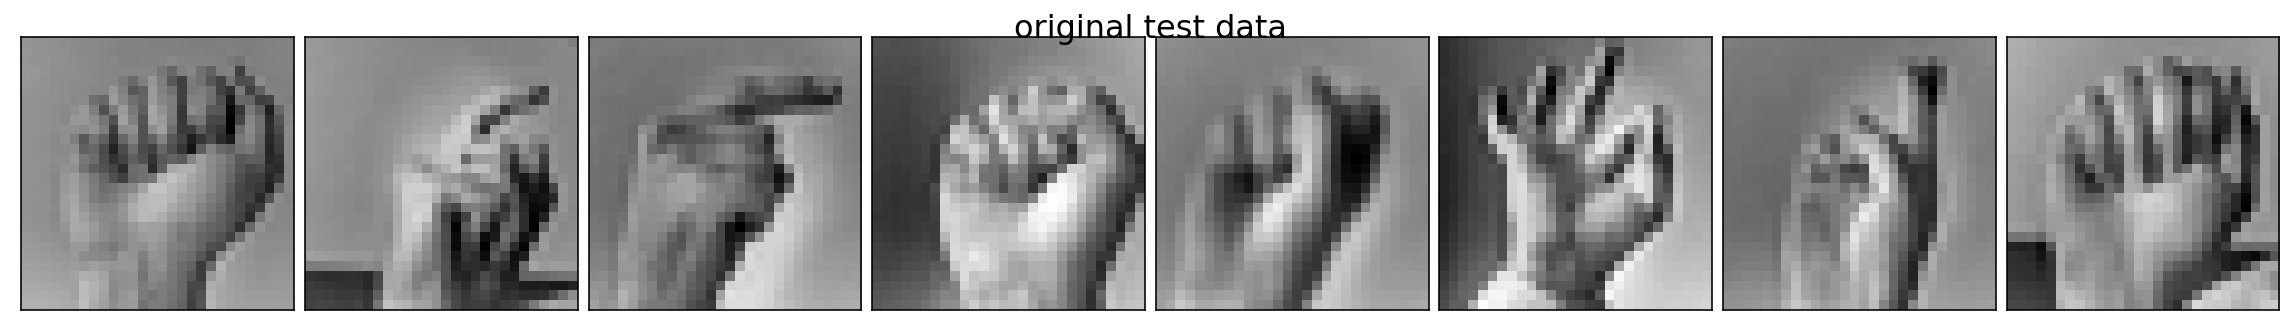

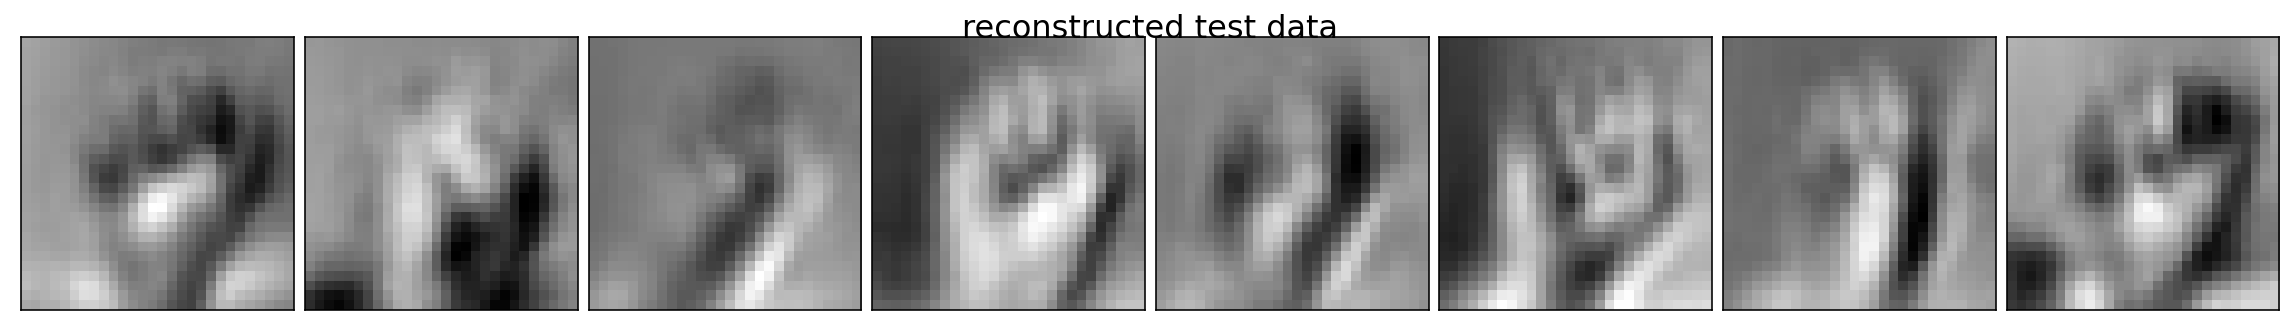

In [20]:
indices = np.random.randint(X_test.shape[0], size=n_recon_images)
plot_gallery("original test data", X_test_centered[indices], n_row=1, n_col=n_recon_images)
X_test_recon = estimator.inverse_transform(estimator.transform(X_test_centered))
plot_gallery("reconstructed test data", X_test_recon[indices], n_row=1, n_col=n_recon_images)

# 今日の課題
* PCA以外の次元圧縮手法について、同様に、元の画像の再構成を実施してみよう。
* その際、圧縮後の次元を増減させると、再構成された画像がどのように変化するか、調べよう。